<center>

*******************************************************************************************
<font size="4">
Phase-Locking Value &nbsp; &nbsp; <br>
</font>

##### 28 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* "Phase-locking value" (PLV) is a measure for synchrony of two or more periodic or recurrent signals. In this context, synchrony is defined as a stable phase difference in time. The program below evaluates PLV upon a sliding window or time sections.

>
* References:

    * Lachaux, J. P., Rodriguez, E., Martinerie, J., & Varela, F. J. (1999). Measuring phase synchrony in brain signals. *Human brain mapping, 8*(4), 194-208. https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C194::AID-HBM4%3E3.0.CO;2-C

    *  Mormann, F., Lehnertz, K., David, P., & Elger, C. E. (2000). Mean phase coherence as a measure for phase synchronization and its application to the EEG of epilepsy patients. *Physica D: Nonlinear Phenomena, 144*(3-4), 358-369. https://doi.org/10.1016/S0167-2789(00)00087-7

    * Bruña, R., Maestú, F., & Pereda, E. (2018). Phase locking value revisited: teaching new tricks to an old dog. *Journal of neural engineering, 15*(5), 056011. https://doi.org/10.1088/1741-2552/aacfe4
>
* Instructions:

    Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sc_path = '../src'
sys.path.append(sc_path)
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


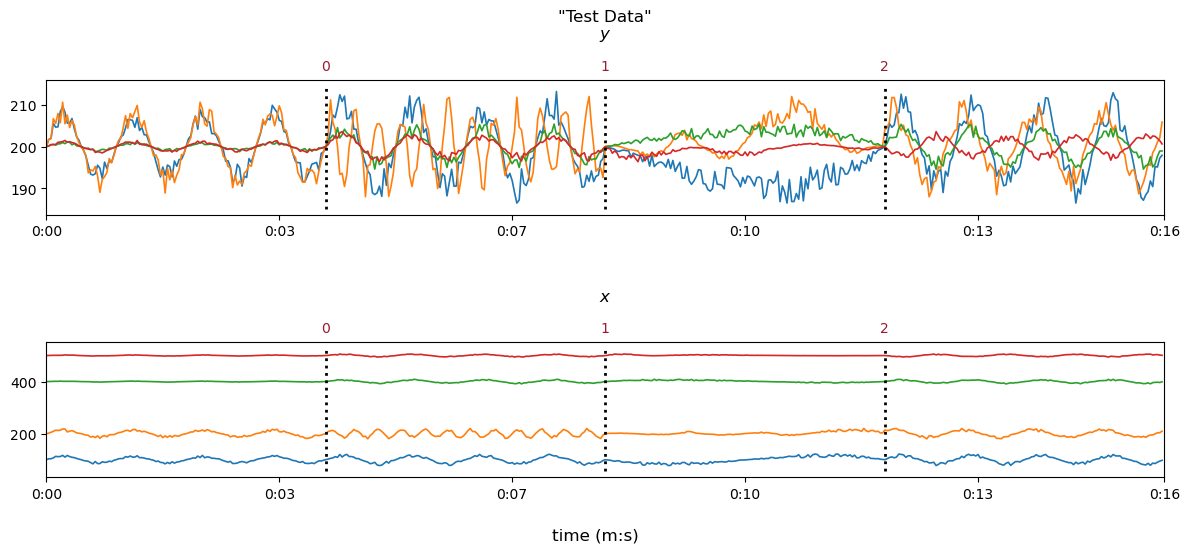

In [2]:
base_freq = 1     # <--- baseline frequency (Hz)
shuffseed = None  # <--- None = don't shuffle sections, int = shuffle sections
noise_fac = 0.5   # <--- noise strength for sections 0, 1, 3

testdata_vars = sc.utils.init_testdatavars(seed=1)
testdata_vars['point_vars'][[0,1,3],...,0] = base_freq
testdata_vars['point_vars'][1,1,...,0] = base_freq * 3
testdata_vars['point_vars'][...,5] = noise_fac
testdata_vars['point_vars'][2,...,5] = 0.5 # noise strength for section 2
if shuffseed is not None:
    rangen = np.random.default_rng(seed=shuffseed)
    rangen.shuffle(testdata_vars['point_vars'])
test_data_1 = sc.ptdata.load( testdata_vars, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

Unshuffled sections:
>0. All synchronised at baseline frequency, but signals 0 and 1 have higher amplitude.
>1. As in section 0, but signal 1 has triple the baseline frequency.
>2. Random oscillation.
>3. All have baseline frequency, but with constant phase differences: 1/8 cycle for signals 0 and 1; 1/2 cycle (*out of phase*) for signals 2 and 3.

Also each signal has distinct random noise.

***
### Low-Pass Filter

In [3]:
apply_LPF = False  # <--- Apply filter

filtparam = { 'filter_type' : 'savgol',         # <--- 'savgol' or 'butter'
               'window_size': 1/(2*base_freq),  # <--- if 'savgol': window size (seconds)
               'order' : 1 }                    # <--- filter's order

# filtparam = { 'filter_type' : 'butter',     # <--- 'savgol' or 'butter'
#               'freq_response' : 'lowpass',  # <--- if 'butter': frequency response
#               'cutoff_freq' : base_freq,    # <--- if 'butter': cutoff frequency (Hz)
#                'order' : 3 }                # <--- filter's order

if apply_LPF:
    test_data_2 = sc.ptdata.smooth( test_data_1, **filtparam )
    test_data_2.visualise( vscale=1.2, dlattr='1.2'  )
else:
    test_data_2 = test_data_1
    print('Low-pass filter not applied.')

Low-pass filter not applied.


***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies the oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

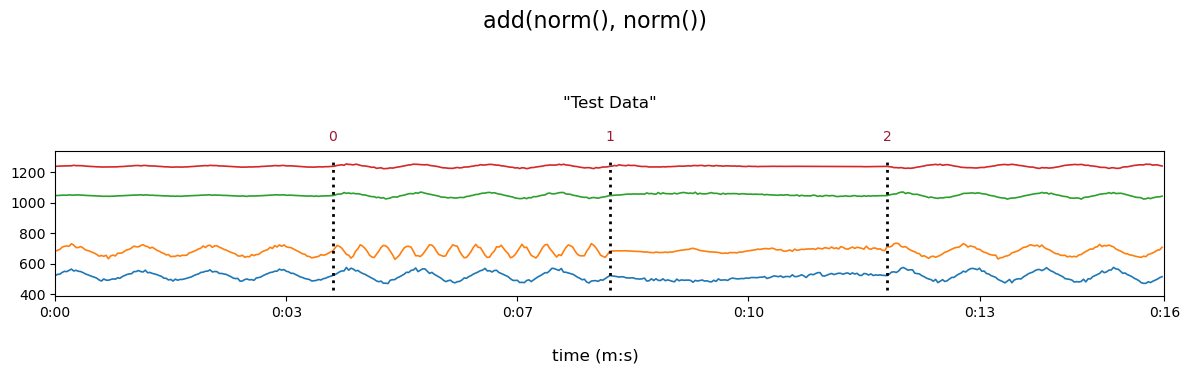

In [4]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_3 = sc.ptdata.speed( test_data_2 )
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_2, order=2, axis=-2 )
    test_data_3 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invalid value for red1D_method')
test_data_3.visualise( vscale=1.4, dlattr='1.2' )

***
### Phase

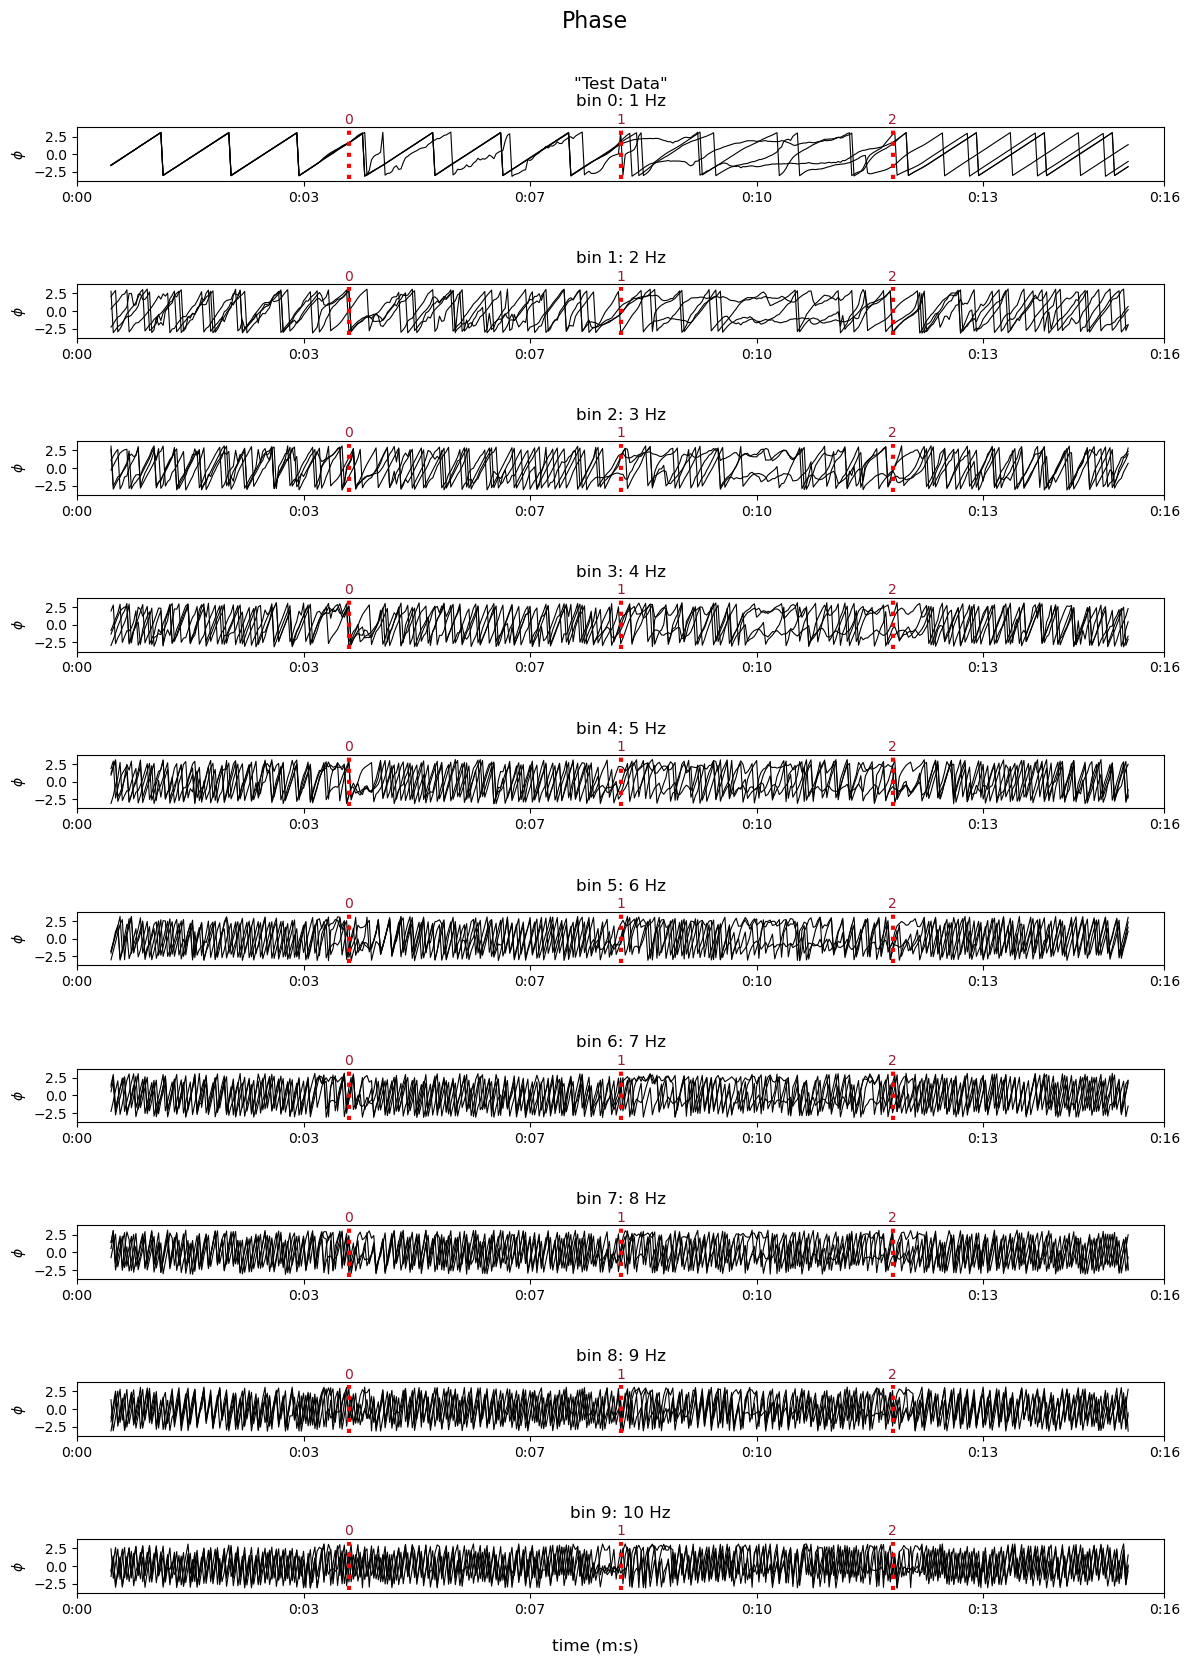

In [5]:
phase_method = 'FFT'            # <--- method for phase angles 'peaks' or 'FFT'
# phase_method = 'peaks'          # <--- method for phase angles 'peaks' or 'FFT'

if phase_method == 'peaks':

    min_dist = base_freq/2      # <--- minimum distance between peaks (seconds)

    phase = sc.ptdata.peaks_to_phase( test_data_3, min_dist=min_dist,
                                      endstart=True, height=0.2, prominence=0.1 )
    phase.visualise( groupby=-1, vscale=0.7 )
    margin = 1/(2*min_dist)

elif phase_method == 'FFT':

    fft_window_s = 1/base_freq  # <--- FFT window's length (seconds)
    sel_freq_bin = slice(0,10)  # <--- select frequency bins (int, slice, or 'all')
    # sel_freq_bin = 0            # <--- select frequency bins (int, slice, or 'all')

    phase = sc.ptdata.fourier( test_data_3, fft_window_s, output='phase' )
    if sel_freq_bin == 'all':
        phase.visualise( vscale=0.7 )
    else:
        phase = sc.ptdata.select(phase, frequency=sel_freq_bin)
        if isinstance(sel_freq_bin,slice): phase.visualise( vscale=0.7 )
        else: phase.visualise( vscale=1.3 )
    margin = fft_window_s/2

else: raise Exception('invalid value for phase_method')

***
### Pairwise PLV

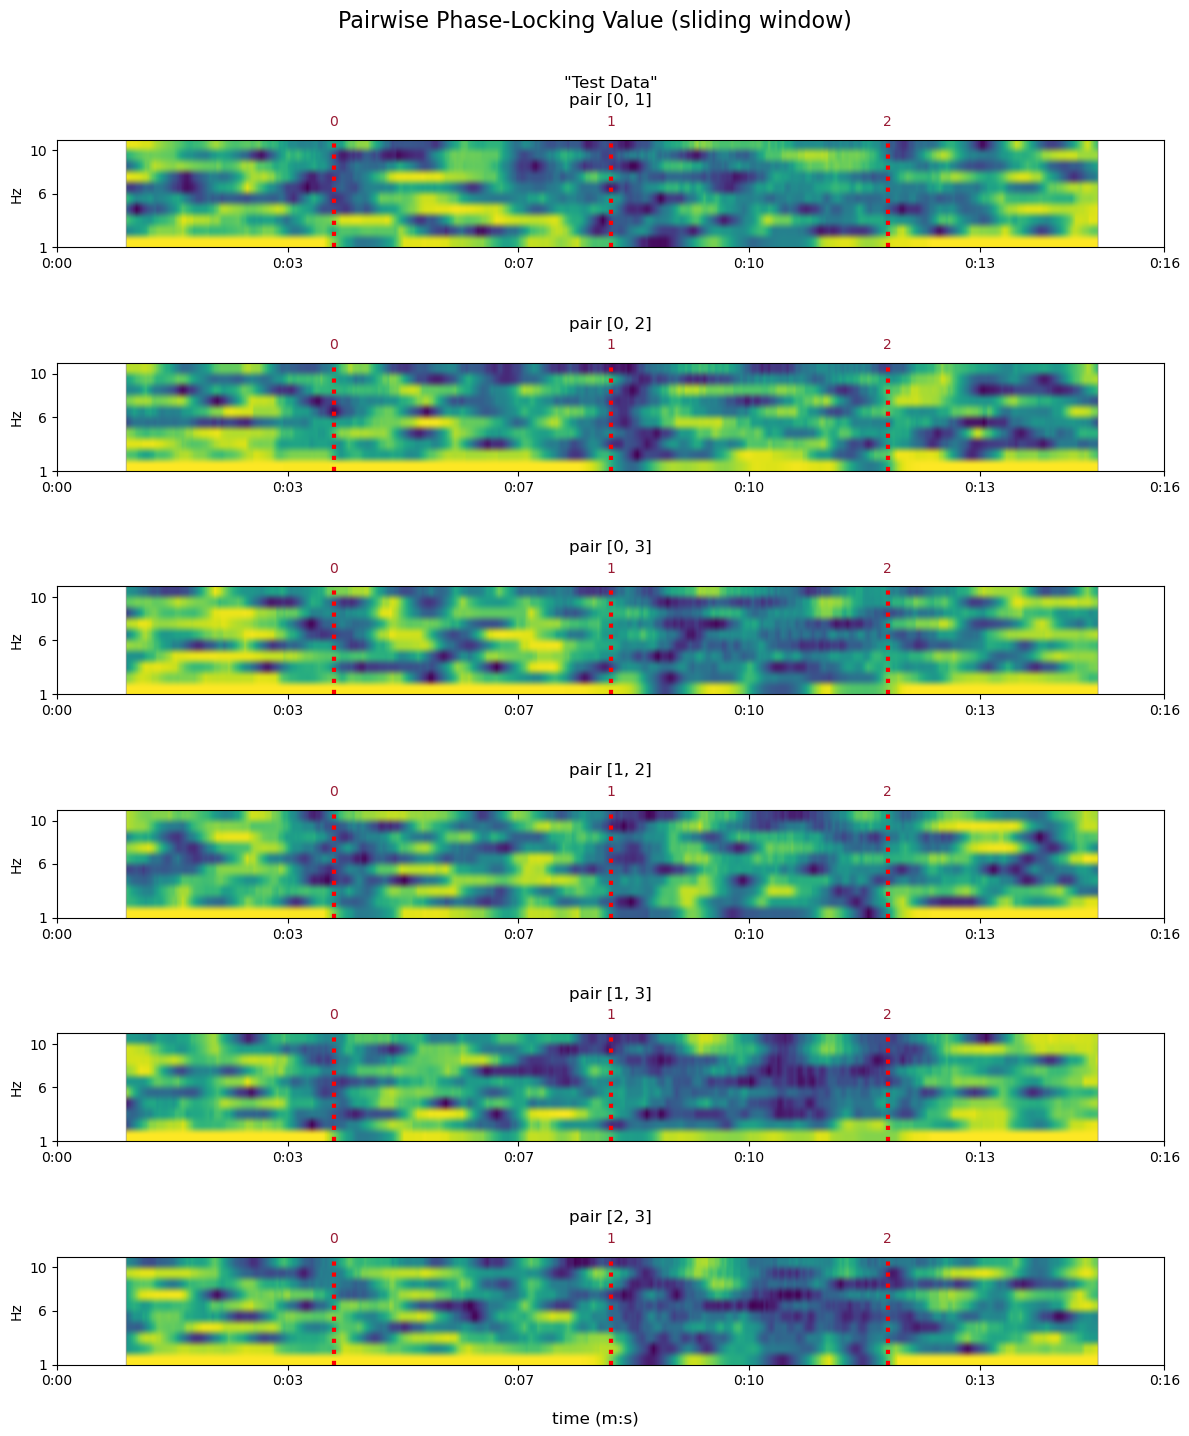

In [6]:
plv_windows = fft_window_s # <--- seconds for sliding window or 'sections'
# plv_windows = 'sections'   # <--- seconds for sliding window or 'sections'

plv = sc.ptdata.plv( phase, plv_windows )
plv.visualise( dlattr='1.2' )

>
#### Average PLV of group

C:\Users\juigmend\local_documents\SynCoord\docs\../src\syncoord\ptdata.py:1212: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


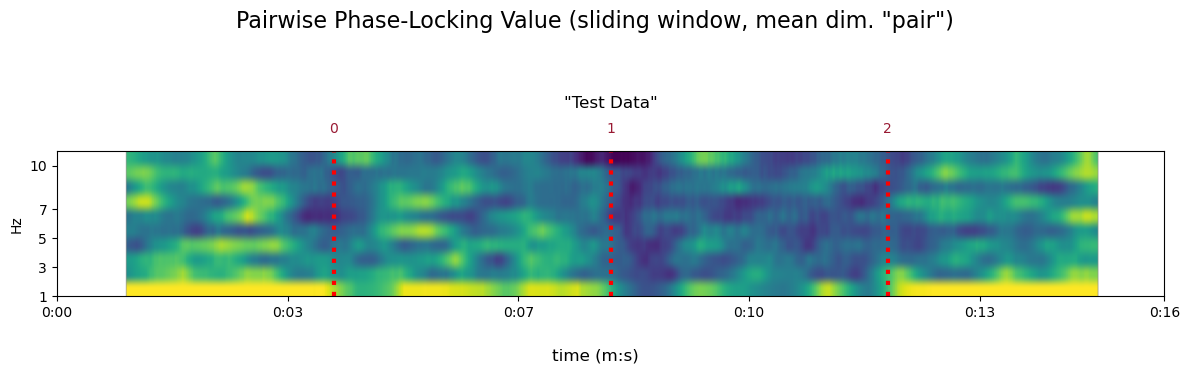

In [7]:
plv_aggr_pairs = sc.ptdata.aggrax( plv, axis=0, function='mean' )
if isinstance(sel_freq_bin,int) and (plv_windows == 'sections'):
    print('means =','['+', '.join([str(v) for v in np.round(plv_aggr_pairs.data[0],3)])+']')
plv_aggr_pairs.visualise( vscale=1.4, dlattr='1.2' )

>
#### Band-average PLV of group

C:\Users\juigmend\local_documents\SynCoord\docs\../src\syncoord\ptdata.py:1212: RuntimeWarning: Mean of empty slice
  dd_out[k] = np.nanmean(dd_in[k],axis=axis)


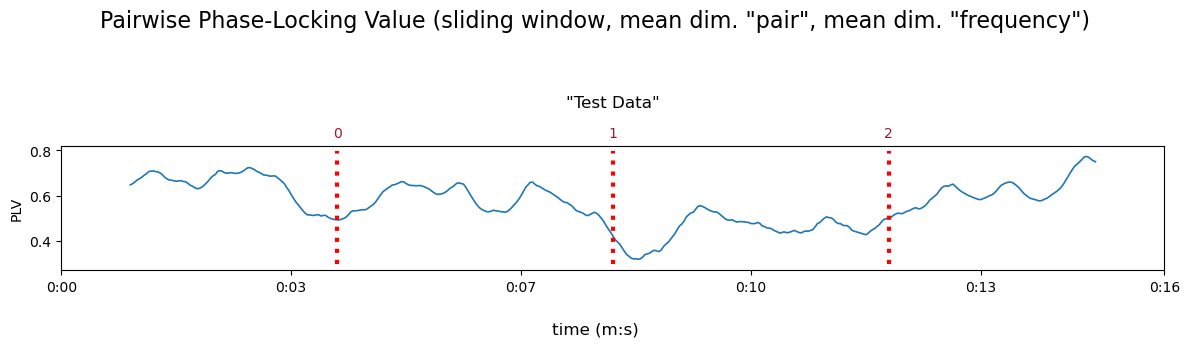

In [8]:
if (phase_method == 'peaks') or isinstance(sel_freq_bin,int):
    print('Process does not apply.')
    plv_aggr_top_sel = plv_aggr_pairs
else:
    plv_aggr_top_sel = sc.ptdata.aggrax( plv_aggr_pairs, axis=0, function='mean' )
    if plv_windows == 'sections':
        plv_aggr_top_sel.visualise( printd=True )
    else:
        plv_aggr_top_sel.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics
Only for sliding window. For sections' PLV the means are already shown in the previous plot.

[0.683 0.603 0.482 0.638]


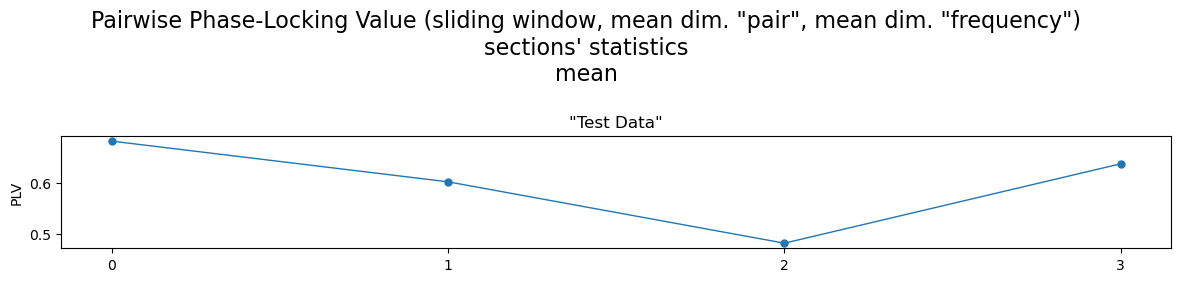

In [9]:
if plv_windows == 'sections':
    print("Statistics not available for sections' PLV")
else:
    sm = (margin + plv_windows/2)
    sec_margins = [[sm,sm] for _ in range(4)] # equivalent to 'secsfromnan'
    # sec_margins = 'secsfromnan' # margins of sections are same as NaN margins
    plv_aggr_top_sel_stats = sc.ptdata.secstats( plv_aggr_top_sel, margins=sec_margins, last=True )
    plv_aggr_top_sel_stats.visualise( statistics='mean', printd=True )